
#### NOTES
- TO DO:
- For each subgroup, divide into quartiles based on target, then analyze
- Breakdown of groups by region/subregion
- Another thing we will need to do is to analyze the data for outliers. Outliers can be single or multivariate.
- From there, we can determine if binning, or other approaches are necessary.
- Other methods of dealing with outliers can be used.

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=2, suppress=True)

In [2]:
df = pd.read_csv('C:\\Users\\aishs\\Desktop\\ITP_Groups.csv')
#df.describe()
df.head()

Unnamed: 0     Name Region Sub-Region  Target  Total Revenue %  \
0          10   Name12      A          H   107.0            130.0   
1          99  Name110      C          J    85.0             90.0   
2          93  Name104      B          Q    83.5             86.0   
3          87   Name96      B          F    88.0             90.0   
4          85   Name94      D          C    83.5             78.0   

   Total Actual Revenue  Total Plan Revenue  Revenue % - A  \
0                4030.5              3109.0           74.0   
1                3723.3              4116.6           86.0   
2                4107.8              4754.4           83.0   
3                2289.4              2533.5           82.0   
4                1314.0              1686.6           84.0   

   Actual Revenue - A  ...  Clients with Pipelines  Call Report Standard %  \
0              1481.5  ...                    22.3                    60.0   
1              2406.1  ...                    34.4                    38.0   
2              1699.5  ...                     8.3                    28.0   
3               947.6  ...                     5.1                    27.0   
4               641.1  ...                    17.9                    85.0   

   Clients with Call Reports  Lab Engagement %  Lab Engagement - Growth %  \
0                       23.3              42.0                       45.0   
1                       29.7              15.0                       25.0   
2                       15.1              35.0                       37.0   
3                        6.0              26.0                       38.0   
4                       23.4              22.0                       38.0   

   Lab Engagement - Stable %  IDEA Status  Engagement % - B  \
0                       40.0          3.0              64.0   
1                        5.0          1.0              52.0   
2                       33.0          2.0              76.0   
3                       14.0          2.0              72.0   
4                        7.0          0.0              61.0   

   Lab Request Count  group  
0               18.0    0.0  
1                2.0    0.0  
2               34.0    0.0  
3               16.0    0.0  
4               26.0    0.0  

[5 rows x 29 columns]

In [3]:
df.shape

(130, 29)

In [4]:
# Preprocessing Methods

def cleanHyphen(df, col, method='zero'):
    """
    In our data set, the 'Lab Engagement' cols have empty values 
    marked with '-'. This function replaces those values.

    Parameters
    ----------

    df : pandas dataframe
    col : column to modify
    method : {'zero' or 'mean'} default 'zero' replaces '-' with '0' or column mean

    Returns
    ----------

    res : shallow copy of orginal dataframe with '-' values replaced. 
    dtype of modified column changed to 'float64'.
    """
    res = df.copy()
    if method == 'mean':
        mean = res[col].mean(axis=1, skipna=True, numeric_only=True)
        res[col].replace(to_replace='-', value=mean, inplace=True)

    elif method == 'zero':
        res[col].replace(to_replace='-', value='0.00', inplace=True)

    res[col] = res[col].astype('float64')
    return res

def catagoryToDummy(df, cols):
    """
    Function returns a dataframe with catagorical values one-hot encoded. 
    Original column is dropped. New columns are concatenated to dataframe 
    on axis 1.
    
    Parameters
    ----------
    df : pandas dataframe
    cols : list of columns to modify
    
    Returns
    ----------
    res : new dataframe with catagorical columns dropped and dummy encoded
    columns appended to the end.
    """
    res = df.copy()
    for c in cols:
        print(c)
        dum = pd.get_dummies(df[c], prefix=c, prefix_sep='_', dtype='float64')
        res = res.drop(labels=c, axis=1)
        res = pd.concat([res, dum], axis=1)
    return res

def convertIdeaStatus(df):
    """
    Represents IDEA status as a continous variable. This catagorical column could also
    be one-hotted
    """
    res = df.copy()
    res['IDEA Status'] = res['IDEA Status'].replace(to_replace='Bronze', value=0.00)
    res['IDEA Status'] = res['IDEA Status'].replace(to_replace='Silver', value=1.00)
    res['IDEA Status'] = res['IDEA Status'].replace(to_replace='Gold', value=2.00)
    res['IDEA Status'] = res['IDEA Status'].replace(to_replace='Platinum', value=3.00)
    return res

def featureBinning(df, cols, binsize=5, method='mean'):
    """
    Equidepth (equal number of members per bin) binning for data smoothing. Last bin may have
    less members.Reimplementation of this function to use % dataset for determining bin size is probably better
    
    parameters
    ----------
    df : pandas dataframe
    cols : list of columns to modify
    binsize : number of members per bin
    method: {'mean' or 'min' or 'max'} default 'mean'

    """
    res = df.copy()
    for c in cols:
        
        # create nparray for binning
        idxtoval = np.zeros((df.shape[0], 3), dtype='float64')
        
        # col0: index
        for i in range(df.shape[0]):
            idxtoval[i,0] = i
        
        # col1: val
        idxtoval[:,1] = df[c].values 
        
        # sort by val
        idxtoval = idxtoval[idxtoval[:,1].argsort()]
        
        # col2: new val
        if method == 'mean':
            for i in range(0,df.shape[0],binsize):
                end = i + binsize if (i + binsize <= df.shape[0]) else df.shape[0]
                print("end")
                print (end)
                idxtoval[i:end,2] += np.mean(idxtoval[i:end,1])
                print("idx")
                print (idxtoval)
        elif method == 'min':
            for i in range(0,df.shape[0],binsize):
                end = i + binsize if (i + binsize <= df.shape[0]) else df.shape[0]
                idxtoval[i:end,2] += idxtoval[i,1]
        elif method == 'max':
            for i in range(0,df.shape[0],binsize):
                end = i + binsize if (i + binsize <= df.shape[0]) else df.shape[0]
                idxtoval[i:end,2] += idxtoval[end-1,1]
        
        # sort by index
        idxtoval = idxtoval[idxtoval[:,0].argsort()]
                
        #add new col
        res[(c + ' (bin)')] = idxtoval[:,2]
         
        # drop original column
        res = res.drop(labels=c, axis=1)
                            
    return res  

In [6]:
# preprocessing pt1

# remove '%'
df = df.replace({'%':''}, regex=True)

# replace missing values
df = cleanHyphen(df, 'Lab Engagement - Growth %','zero')
df = cleanHyphen(df, 'Lab Engagement - Stable %','zero')

# one hot 'Region' column
# df = catagoryToDummy(df, ['Region'])

# convert idea status to continuous variable 
df = convertIdeaStatus(df)

# save/drop other catgorical columns: will look into 'Region' and 'Sub-Region' later
catagories = df.loc[:,'Name':'Sub-Region'].copy()
df = df.drop(['Name', 'Region', 'Sub-Region', 'ICTL'], axis=1)

# drop NaN rows
df = df.dropna(axis=0)

# convert type to float64
df = df.astype('float64')

In [7]:
def featureBinning(df, cols, binsize=5, method='mean'):
    """
    Equidepth (equal number of members per bin) binning for data smoothing. Last bin may have
    less members.Reimplementation of this function to use % dataset for determining bin size is probably better
    
    parameters
    ----------
    df : pandas dataframe
    cols : list of columns to modify
    binsize : number of members per bin
    method: {'mean' or 'min' or 'max'} default 'mean'

    """
    res = df.copy()
    for c in cols:
        
        # create nparray for binning
        idxtoval = np.zeros((df.shape[0], 3), dtype='float64')
        
        # col0: index
        for i in range(df.shape[0]):
            idxtoval[i,0] = i
        
        # col1: val
        idxtoval[:,1] = df[c].values 
        
        # sort by val
        idxtoval = idxtoval[idxtoval[:,1].argsort()]
        
        # col2: new val
        if method == 'mean':
            for i in range(0,df.shape[0],binsize):
                end = i + binsize if (i + binsize <= df.shape[0]) else df.shape[0]
                print("end")
                print (end)
                print("idxtoval[i:end,2]")
                print(idxtoval[i:end,2])
                print("idxtoval[i:end,1]")
                print(idxtoval[i:end,1])
                print("np.mean(idxtoval[i:end,1])")
                print(np.mean(idxtoval[i:end,1]))
                idxtoval[i:end,2] += np.mean(idxtoval[i:end,1])
                print("idx")
                print (idxtoval)
        elif method == 'min':
            for i in range(0,df.shape[0],binsize):
                end = i + binsize if (i + binsize <= df.shape[0]) else df.shape[0]
                idxtoval[i:end,2] += idxtoval[i,1]
        elif method == 'max':
            for i in range(0,df.shape[0],binsize):
                end = i + binsize if (i + binsize <= df.shape[0]) else df.shape[0]
                idxtoval[i:end,2] += idxtoval[end-1,1]
        
        # sort by index
        idxtoval = idxtoval[idxtoval[:,0].argsort()]
                
        #add new col
        res[(c + ' (bin)')] = idxtoval[:,2]
         
        # drop original column
        res = res.drop(labels=c, axis=1)
                            
    return res 

In [8]:
featureBinning(df,df.loc[:])

end
5
idxtoval[i:end,2]
[0. 0. 0. 0. 0.]
idxtoval[i:end,1]
[ 0. 44. 52. 53. 55.]
np.mean(idxtoval[i:end,1])
40.8
idx
[[129.    0.   40.8]
 [113.   44.   40.8]
 [128.   52.   40.8]
 [105.   53.   40.8]
 [107.   55.   40.8]
 [118.   55.    0. ]
 [119.   61.    0. ]
 [114.   63.    0. ]
 [116.   65.    0. ]
 [108.   66.    0. ]
 [122.   67.    0. ]
 [102.   68.    0. ]
 [ 42.   69.    0. ]
 [124.   70.    0. ]
 [126.   71.    0. ]
 [123.   72.    0. ]
 [ 96.   72.    0. ]
 [121.   72.    0. ]
 [ 82.   73.    0. ]
 [106.   74.    0. ]
 [ 47.   75.    0. ]
 [125.   75.    0. ]
 [112.   77.    0. ]
 [110.   77.    0. ]
 [ 78.   77.    0. ]
 [ 84.   78.    0. ]
 [ 37.   78.    0. ]
 [ 44.   78.    0. ]
 [ 62.   79.    0. ]
 [ 97.   79.    0. ]
 [ 95.   79.    0. ]
 [109.   79.    0. ]
 [ 88.   79.    0. ]
 [ 94.   81.    0. ]
 [ 93.   81.    0. ]
 [ 74.   82.    0. ]
 [ 72.   82.    0. ]
 [ 83.   82.    0. ]
 [ 71.   82.    0. ]
 [ 99.   82.    0. ]
 [101.   82.    0. ]
 [ 90.   83.    0. ]
 

end
70
idxtoval[i:end,2]
[0. 0. 0. 0. 0.]
idxtoval[i:end,1]
[400.7 408.1 416.7 422.1 423.8]
np.mean(idxtoval[i:end,1])
414.28000000000003
idx
[[  129.       0.      31.28]
 [  127.      21.2     31.28]
 [  125.      41.9     31.28]
 [  100.      42.3     31.28]
 [  128.      51.      31.28]
 [   87.      55.1     65.7 ]
 [  120.      55.7     65.7 ]
 [  121.      60.2     65.7 ]
 [   11.      77.8     65.7 ]
 [  118.      79.7     65.7 ]
 [  117.      83.7    101.22]
 [  113.      84.2    101.22]
 [   80.     100.6    101.22]
 [  126.     115.6    101.22]
 [   78.     122.     101.22]
 [  124.     127.8    137.12]
 [  115.     130.4    137.12]
 [  123.     137.2    137.12]
 [   89.     144.2    137.12]
 [  101.     146.     137.12]
 [   60.     147.9    153.48]
 [   77.     149.9    153.48]
 [  110.     154.5    153.48]
 [  112.     155.6    153.48]
 [  119.     159.5    153.48]
 [   68.     172.     191.36]
 [  103.     175.8    191.36]
 [  107.     180.1    191.36]
 [   81.     212.9

60
idxtoval[i:end,2]
[0. 0. 0. 0. 0.]
idxtoval[i:end,1]
[84. 85. 85. 85. 86.]
np.mean(idxtoval[i:end,1])
85.0
idx
[[129.    0.   36.8]
 [113.   36.   36.8]
 [122.   47.   36.8]
 [109.   50.   36.8]
 [104.   51.   36.8]
 [128.   54.   56.6]
 [ 14.   56.   56.6]
 [114.   57.   56.6]
 [123.   57.   56.6]
 [119.   59.   56.6]
 [107.   59.   63.4]
 [106.   62.   63.4]
 [ 78.   64.   63.4]
 [118.   65.   63.4]
 [ 32.   67.   63.4]
 [  4.   67.   69.6]
 [ 85.   69.   69.6]
 [ 13.   70.   69.6]
 [125.   71.   69.6]
 [ 76.   71.   69.6]
 [116.   72.   72.8]
 [ 38.   72.   72.8]
 [ 99.   73.   72.8]
 [121.   73.   72.8]
 [ 82.   74.   72.8]
 [ 10.   74.   75.4]
 [124.   75.   75.4]
 [112.   75.   75.4]
 [ 94.   76.   75.4]
 [105.   77.   75.4]
 [ 71.   77.   78. ]
 [ 72.   77.   78. ]
 [ 47.   78.   78. ]
 [ 62.   79.   78. ]
 [ 67.   79.   78. ]
 [ 97.   79.   79.6]
 [ 96.   79.   79.6]
 [102.   79.   79.6]
 [ 75.   80.   79.6]
 [ 93.   81.   79.6]
 [ 16.   81.   81.8]
 [ 42.   82.   81.8]
 [ 6

 [  51.   7059.5     0.  ]]
end
80
idxtoval[i:end,2]
[0. 0. 0. 0. 0.]
idxtoval[i:end,1]
[287.1 292.2 299.2 302.5 310.5]
np.mean(idxtoval[i:end,1])
298.3
idx
[[ 129.      0.     18.88]
 [ 127.      9.     18.88]
 [ 125.     23.5    18.88]
 [ 128.     24.8    18.88]
 [ 100.     37.1    18.88]
 [ 121.     37.5    46.24]
 [  87.     46.1    46.24]
 [ 113.     47.5    46.24]
 [ 120.     48.4    46.24]
 [ 123.     51.7    46.24]
 [ 117.     58.9    63.52]
 [  78.     58.9    63.52]
 [ 101.     66.2    63.52]
 [  11.     66.3    63.52]
 [  80.     67.3    63.52]
 [  60.     68.1    76.92]
 [ 118.     69.3    76.92]
 [ 104.     79.4    76.92]
 [ 114.     82.4    76.92]
 [  76.     85.4    76.92]
 [ 126.     90.9    95.  ]
 [ 109.     91.2    95.  ]
 [ 119.     92.7    95.  ]
 [ 110.     99.9    95.  ]
 [  41.    100.3    95.  ]
 [ 115.    105.4   111.98]
 [  68.    109.2   111.98]
 [ 124.    110.2   111.98]
 [ 112.    111.6   111.98]
 [  54.    123.5   111.98]
 [  89.    132.4   137.28]
 [   3

 [  51.   7700.6     0.  ]]
end
120
idxtoval[i:end,2]
[0. 0. 0. 0. 0.]
idxtoval[i:end,1]
[1980.9 2006.1 2059.7 2574.8 2798.8]
np.mean(idxtoval[i:end,1])
2284.06
idx
[[ 127.      9.3    31.12]
 [ 129.     27.3    31.12]
 [ 125.     33.     31.12]
 [ 100.     40.9    31.12]
 [ 117.     45.1    31.12]
 [ 128.     46.2    52.18]
 [ 121.     51.1    52.18]
 [  11.     52.5    52.18]
 [  80.     55.4    52.18]
 [  87.     55.7    52.18]
 [ 120.     57.3    78.78]
 [ 101.     80.3    78.78]
 [  60.     83.1    78.78]
 [ 110.     83.2    78.78]
 [ 123.     90.     78.78]
 [ 126.     90.6   101.34]
 [  78.     91.4   101.34]
 [  41.    104.1   101.34]
 [ 118.    106.4   101.34]
 [ 115.    114.2   101.34]
 [  76.    120.6   129.76]
 [  68.    121.5   129.76]
 [ 113.    132.7   129.76]
 [  89.    136.3   129.76]
 [ 103.    137.7   129.76]
 [  43.    140.8   143.14]
 [   3.    141.3   143.14]
 [  54.    142.2   143.14]
 [ 114.    144.1   143.14]
 [ 124.    147.3   143.14]
 [ 112.    148.4   152.26

 [  51.   8489.      0.  ]]
end
20
idxtoval[i:end,2]
[0. 0. 0. 0. 0.]
idxtoval[i:end,1]
[26.2 26.5 28.5 28.7 31.8]
np.mean(idxtoval[i:end,1])
28.340000000000003
idx
[[ 129.      0.      6.38]
 [ 100.      5.2     6.38]
 [ 120.      7.3     6.38]
 [  87.      9.      6.38]
 [ 118.     10.4     6.38]
 [  11.     11.6    13.42]
 [  89.     11.8    13.42]
 [ 127.     12.2    13.42]
 [  77.     13.9    13.42]
 [ 124.     17.6    13.42]
 [ 125.     18.4    23.12]
 [ 121.     22.7    23.12]
 [ 126.     24.7    23.12]
 [ 117.     24.8    23.12]
 [ 115.     25.     23.12]
 [ 128.     26.2    28.34]
 [  74.     26.5    28.34]
 [ 103.     28.5    28.34]
 [  81.     28.7    28.34]
 [  90.     31.8    28.34]
 [  80.     33.3     0.  ]
 [ 107.     35.9     0.  ]
 [ 113.     36.7     0.  ]
 [  73.     39.3     0.  ]
 [  70.     41.7     0.  ]
 [ 112.     44.1     0.  ]
 [  37.     47.3     0.  ]
 [  21.     50.4     0.  ]
 [ 110.     54.6     0.  ]
 [  53.     55.5     0.  ]
 [ 111.     58.6     0.  

[[ 129.      0.      6.38]
 [ 100.      5.2     6.38]
 [ 120.      7.3     6.38]
 [  87.      9.      6.38]
 [ 118.     10.4     6.38]
 [  11.     11.6    13.42]
 [  89.     11.8    13.42]
 [ 127.     12.2    13.42]
 [  77.     13.9    13.42]
 [ 124.     17.6    13.42]
 [ 125.     18.4    23.12]
 [ 121.     22.7    23.12]
 [ 126.     24.7    23.12]
 [ 117.     24.8    23.12]
 [ 115.     25.     23.12]
 [ 128.     26.2    28.34]
 [  74.     26.5    28.34]
 [ 103.     28.5    28.34]
 [  81.     28.7    28.34]
 [  90.     31.8    28.34]
 [  80.     33.3    37.38]
 [ 107.     35.9    37.38]
 [ 113.     36.7    37.38]
 [  73.     39.3    37.38]
 [  70.     41.7    37.38]
 [ 112.     44.1    50.38]
 [  37.     47.3    50.38]
 [  21.     50.4    50.38]
 [ 110.     54.6    50.38]
 [  53.     55.5    50.38]
 [ 111.     58.6    61.74]
 [  82.     60.     61.74]
 [  68.     62.8    61.74]
 [  78.     63.1    61.74]
 [ 102.     64.2    61.74]
 [ 119.     66.9    73.92]
 [ 108.     72.9    73.92]
 

[[129.    0.   25.6]
 [127.   16.   25.6]
 [128.   29.   25.6]
 [113.   40.   25.6]
 [123.   43.   25.6]
 [121.   44.   52.8]
 [100.   49.   52.8]
 [120.   55.   52.8]
 [125.   57.   52.8]
 [104.   59.   52.8]
 [119.   60.   61.6]
 [117.   60.   61.6]
 [124.   62.   61.6]
 [101.   63.   61.6]
 [ 59.   63.   61.6]
 [126.   65.    0. ]
 [122.   67.    0. ]
 [ 27.   68.    0. ]
 [115.   70.    0. ]
 [109.   72.    0. ]
 [112.   73.    0. ]
 [ 82.   74.    0. ]
 [106.   74.    0. ]
 [  3.   75.    0. ]
 [ 99.   75.    0. ]
 [ 93.   75.    0. ]
 [ 83.   75.    0. ]
 [ 87.   75.    0. ]
 [ 89.   75.    0. ]
 [  7.   75.    0. ]
 [110.   76.    0. ]
 [111.   76.    0. ]
 [118.   76.    0. ]
 [ 57.   76.    0. ]
 [ 85.   77.    0. ]
 [103.   77.    0. ]
 [ 38.   78.    0. ]
 [ 54.   79.    0. ]
 [  1.   80.    0. ]
 [ 98.   80.    0. ]
 [ 52.   80.    0. ]
 [ 40.   80.    0. ]
 [ 42.   81.    0. ]
 [ 13.   81.    0. ]
 [ 92.   81.    0. ]
 [ 19.   81.    0. ]
 [ 66.   81.    0. ]
 [ 61.   82. 

 [     56.   1499525.5        0.  ]]
end
55
idxtoval[i:end,2]
[0. 0. 0. 0. 0.]
idxtoval[i:end,1]
[61009.2 61864.6 63765.6 64035.3 64081.3]
np.mean(idxtoval[i:end,1])
62951.2
idx
[[    129.         0.      4738.72]
 [    127.      1678.9     4738.72]
 [    113.      7031.5     4738.72]
 [    128.      7132.2     4738.72]
 [    125.      7851.      4738.72]
 [    121.     10453.4    12712.18]
 [    123.     11123.1    12712.18]
 [    117.     13218.5    12712.18]
 [    100.     13218.8    12712.18]
 [    104.     15547.1    12712.18]
 [    120.     19478.8    21078.82]
 [     11.     19719.3    21078.82]
 [    101.     21015.8    21078.82]
 [    110.     21990.5    21078.82]
 [     78.     23189.7    21078.82]
 [     60.     23377.8    25076.2 ]
 [     83.     23889.1    25076.2 ]
 [     80.     25053.7    25076.2 ]
 [     54.     25698.6    25076.2 ]
 [    124.     27361.8    25076.2 ]
 [     87.     29507.6    29937.78]
 [    115.     29550.2    29937.78]
 [    126.     29630.5    2993

 [     51.   1699749.7        0.  ]]
end
70
idxtoval[i:end,2]
[0. 0. 0. 0. 0.]
idxtoval[i:end,1]
[89115.2 89974.5 91844.7 94061.3 94266.9]
np.mean(idxtoval[i:end,1])
91852.51999999999
idx
[[    127.     10783.7    16425.5 ]
 [    125.     13843.3    16425.5 ]
 [    113.     17562.2    16425.5 ]
 [    129.     17857.1    16425.5 ]
 [    117.     22081.2    16425.5 ]
 [     11.     22440.7    24181.28]
 [    121.     23649.3    24181.28]
 [    128.     24313.3    24181.28]
 [     60.     24746.8    24181.28]
 [    123.     25756.3    24181.28]
 [    104.     26273.4    27858.26]
 [    100.     27084.7    27858.26]
 [     78.     27477.8    27858.26]
 [    110.     28850.     27858.26]
 [     80.     29605.4    27858.26]
 [     83.     31828.3    34488.68]
 [     54.     32598.1    34488.68]
 [    101.     33143.7    34488.68]
 [    120.     35711.8    34488.68]
 [     87.     39161.5    34488.68]
 [     69.     39348.3    40820.46]
 [     41.     40087.4    40820.46]
 [     32.     41149

[[129.     0.3    1.  ]
 [127.     0.6    1.  ]
 [105.     0.7    1.  ]
 [117.     1.3    1.  ]
 [100.     2.1    1.  ]
 [118.     2.4    2.74]
 [119.     2.7    2.74]
 [ 87.     2.7    2.74]
 [ 43.     2.9    2.74]
 [125.     3.     2.74]
 [101.     3.1    3.42]
 [121.     3.1    3.42]
 [  4.     3.4    3.42]
 [ 22.     3.6    3.42]
 [ 42.     3.9    3.42]
 [ 12.     3.9    4.06]
 [128.     4.     4.06]
 [ 17.     4.     4.06]
 [ 70.     4.1    4.06]
 [ 60.     4.3    4.06]
 [109.     4.3    4.48]
 [ 44.     4.4    4.48]
 [ 11.     4.4    4.48]
 [  3.     4.6    4.48]
 [ 97.     4.7    4.48]
 [  2.     4.7    4.84]
 [104.     4.7    4.84]
 [ 58.     4.9    4.84]
 [  1.     4.9    4.84]
 [ 39.     5.     4.84]
 [114.     5.     5.1 ]
 [102.     5.     5.1 ]
 [ 57.     5.1    5.1 ]
 [ 88.     5.1    5.1 ]
 [116.     5.3    5.1 ]
 [122.     5.3    5.3 ]
 [ 38.     5.3    5.3 ]
 [110.     5.3    5.3 ]
 [ 13.     5.3    5.3 ]
 [ 61.     5.3    5.3 ]
 [ 27.     5.4    5.48]
 [113.     5.4  

 [  1.   97.    0. ]]
end
65
idxtoval[i:end,2]
[0. 0. 0. 0. 0.]
idxtoval[i:end,1]
[38. 39. 39. 40. 40.]
np.mean(idxtoval[i:end,1])
39.2
idx
[[129.    0.    0.8]
 [127.    0.    0.8]
 [125.    0.    0.8]
 [ 55.    0.    0.8]
 [ 96.    4.    0.8]
 [ 49.    6.    8.6]
 [  0.    8.    8.6]
 [114.    9.    8.6]
 [ 58.    9.    8.6]
 [ 65.   11.    8.6]
 [ 76.   11.   11.8]
 [117.   11.   11.8]
 [128.   11.   11.8]
 [113.   13.   11.8]
 [112.   13.   11.8]
 [ 95.   14.   15. ]
 [ 88.   14.   15. ]
 [ 43.   15.   15. ]
 [ 92.   16.   15. ]
 [ 67.   16.   15. ]
 [ 80.   17.   18.2]
 [111.   17.   18.2]
 [ 97.   18.   18.2]
 [122.   19.   18.2]
 [ 51.   20.   18.2]
 [ 33.   20.   21. ]
 [103.   20.   21. ]
 [ 69.   21.   21. ]
 [106.   21.   21. ]
 [ 86.   23.   21. ]
 [ 91.   23.   25. ]
 [ 63.   23.   25. ]
 [  8.   24.   25. ]
 [104.   27.   25. ]
 [ 70.   28.   25. ]
 [ 41.   28.   29.2]
 [ 46.   29.   29.2]
 [102.   29.   29.2]
 [123.   30.   29.2]
 [ 50.   30.   29.2]
 [108.   32.   32.6]

 [105.  100.    0. ]]
end
55
idxtoval[i:end,2]
[0. 0. 0. 0. 0.]
idxtoval[i:end,1]
[38. 38. 38. 38. 39.]
np.mean(idxtoval[i:end,1])
38.2
idx
[[112.    5.    9.8]
 [ 96.    6.    9.8]
 [126.    9.    9.8]
 [116.   14.    9.8]
 [107.   15.    9.8]
 [ 95.   16.   16.4]
 [ 14.   16.   16.4]
 [119.   16.   16.4]
 [109.   17.   16.4]
 [ 55.   17.   16.4]
 [ 91.   19.   19.8]
 [  0.   20.   19.8]
 [ 43.   20.   19.8]
 [114.   20.   19.8]
 [ 33.   20.   19.8]
 [ 50.   20.   21. ]
 [ 65.   21.   21. ]
 [ 70.   21.   21. ]
 [ 41.   21.   21. ]
 [117.   22.   21. ]
 [ 76.   23.   24.6]
 [108.   24.   24.6]
 [111.   25.   24.6]
 [127.   25.   24.6]
 [  8.   26.   24.6]
 [ 86.   27.   27.4]
 [ 49.   27.   27.4]
 [ 93.   27.   27.4]
 [ 92.   28.   27.4]
 [ 69.   28.   27.4]
 [ 75.   28.   28.4]
 [ 78.   28.   28.4]
 [  3.   28.   28.4]
 [124.   29.   28.4]
 [ 27.   29.   28.4]
 [123.   30.   31.6]
 [102.   31.   31.6]
 [122.   32.   31.6]
 [ 46.   32.   31.6]
 [104.   33.   31.6]
 [ 56.   34.   34.8]

 [ 48.    60.1    0.  ]]
end
90
idxtoval[i:end,2]
[0. 0. 0. 0. 0.]
idxtoval[i:end,1]
[4.4 4.4 4.6 4.7 4.7]
np.mean(idxtoval[i:end,1])
4.5600000000000005
idx
[[129.     0.1    0.26]
 [127.     0.1    0.26]
 [117.     0.3    0.26]
 [ 96.     0.4    0.26]
 [119.     0.4    0.26]
 [126.     0.6    0.64]
 [ 43.     0.6    0.64]
 [112.     0.6    0.64]
 [105.     0.7    0.64]
 [109.     0.7    0.64]
 [116.     0.7    0.92]
 [ 70.     0.9    0.92]
 [ 95.     1.     0.92]
 [107.     1.     0.92]
 [114.     1.     0.92]
 [ 41.     1.1    1.1 ]
 [ 50.     1.1    1.1 ]
 [ 33.     1.1    1.1 ]
 [125.     1.1    1.1 ]
 [101.     1.1    1.1 ]
 [  3.     1.3    1.3 ]
 [ 14.     1.3    1.3 ]
 [108.     1.3    1.3 ]
 [121.     1.3    1.3 ]
 [118.     1.3    1.3 ]
 [128.     1.4    1.56]
 [104.     1.6    1.56]
 [  4.     1.6    1.56]
 [ 78.     1.6    1.56]
 [ 27.     1.6    1.56]
 [ 76.     1.6    1.62]
 [ 60.     1.6    1.62]
 [ 55.     1.6    1.62]
 [102.     1.6    1.62]
 [124.     1.7    1.62]
 [1

[[129.    0.    0. ]
 [ 53.    0.    0. ]
 [128.    0.    0. ]
 [ 66.    0.    0. ]
 [ 68.    0.    0. ]
 [ 69.    0.    0. ]
 [ 77.    0.    0. ]
 [ 78.    0.    0. ]
 [ 24.    0.    0. ]
 [ 79.    0.    0. ]
 [ 80.    0.    0. ]
 [ 85.    0.    0. ]
 [ 87.    0.    0. ]
 [ 89.    0.    0. ]
 [100.    0.    0. ]
 [ 41.    0.    0. ]
 [102.    0.    0. ]
 [104.    0.    0. ]
 [  1.    0.    0. ]
 [127.    0.    0. ]
 [125.    0.    0. ]
 [124.    0.    0. ]
 [123.    0.    0. ]
 [121.    0.    0. ]
 [103.    0.    0. ]
 [120.    0.    0. ]
 [115.    0.    0. ]
 [113.    0.    0. ]
 [110.    0.    0. ]
 [105.    0.    0. ]
 [117.    0.    2.6]
 [ 34.    0.    2.6]
 [ 18.    3.    2.6]
 [109.    5.    2.6]
 [ 64.    5.    2.6]
 [  6.    6.    7.6]
 [111.    6.    7.6]
 [119.    8.    7.6]
 [ 99.    8.    7.6]
 [ 55.   10.    7.6]
 [ 29.   10.    0. ]
 [  9.   10.    0. ]
 [ 47.   10.    0. ]
 [ 74.   11.    0. ]
 [ 48.   11.    0. ]
 [ 81.   13.    0. ]
 [ 28.   13.    0. ]
 [126.   13. 

[[129.   0.   0.]
 [ 27.   0.   0.]
 [ 89.   0.   0.]
 [ 29.   0.   0.]
 [ 87.   0.   0.]
 [ 85.   0.   0.]
 [ 81.   0.   0.]
 [ 80.   0.   0.]
 [ 34.   0.   0.]
 [ 79.   0.   0.]
 [ 78.   0.   0.]
 [ 37.   0.   0.]
 [ 77.   0.   0.]
 [ 74.   0.   0.]
 [ 69.   0.   0.]
 [ 41.   0.   0.]
 [ 68.   0.   0.]
 [ 66.   0.   0.]
 [128.   0.   0.]
 [ 60.   0.   0.]
 [ 55.   0.   0.]
 [ 47.   0.   0.]
 [100.   0.   0.]
 [101.   0.   0.]
 [ 24.   0.   0.]
 [102.   0.   0.]
 [  1.   0.   0.]
 [127.   0.   0.]
 [125.   0.   0.]
 [124.   0.   0.]
 [123.   0.   0.]
 [121.   0.   0.]
 [120.   0.   0.]
 [119.   0.   0.]
 [118.   0.   0.]
 [117.   0.   0.]
 [ 54.   0.   0.]
 [115.   0.   0.]
 [ 13.   0.   0.]
 [ 14.   0.   0.]
 [112.   0.   0.]
 [110.   0.   0.]
 [109.   0.   0.]
 [105.   0.   0.]
 [104.   0.   0.]
 [103.   0.   0.]
 [ 22.   0.   0.]
 [113.   0.   0.]
 [ 53.   0.   0.]
 [ 18.   6.   0.]
 [ 64.   9.   0.]
 [ 36.   9.   0.]
 [ 48.  12.   0.]
 [ 30.  13.   0.]
 [111.  13.   0.]
 [  6.  13

 [  0.  100.    0. ]]
end
80
idxtoval[i:end,2]
[0. 0. 0. 0. 0.]
idxtoval[i:end,1]
[17. 17. 17. 18. 20.]
np.mean(idxtoval[i:end,1])
17.8
idx
[[ 64.    0.    0. ]
 [ 91.    0.    0. ]
 [ 90.    0.    0. ]
 [ 89.    0.    0. ]
 [ 87.    0.    0. ]
 [ 85.    0.    0. ]
 [ 83.    0.    0. ]
 [ 80.    0.    0. ]
 [ 79.    0.    0. ]
 [ 97.    0.    0. ]
 [ 78.    0.    0. ]
 [ 76.    0.    0. ]
 [ 69.    0.    0. ]
 [ 68.    0.    0. ]
 [ 66.    0.    0. ]
 [128.    0.    0. ]
 [ 59.    0.    0. ]
 [ 53.    0.    0. ]
 [ 50.    0.    0. ]
 [ 77.    0.    0. ]
 [ 44.    0.    0. ]
 [ 99.    0.    0. ]
 [102.    0.    0. ]
 [127.    0.    0. ]
 [126.    0.    0. ]
 [125.    0.    0. ]
 [124.    0.    0. ]
 [123.    0.    0. ]
 [121.    0.    0. ]
 [120.    0.    0. ]
 [117.    0.    0. ]
 [100.    0.    0. ]
 [116.    0.    0. ]
 [114.    0.    0. ]
 [113.    0.    0. ]
 [111.    0.    0. ]
 [110.    0.    0. ]
 [108.    0.    0. ]
 [105.    0.    0. ]
 [104.    0.    0. ]
 [103.    0.    0. ]

[[ 84.    0.    0.8]
 [ 64.    1.    0.8]
 [ 48.    1.    0.8]
 [ 70.    1.    0.8]
 [ 76.    1.    0.8]
 [ 79.    1.    1. ]
 [ 85.    1.    1. ]
 [ 28.    1.    1. ]
 [ 56.    1.    1. ]
 [ 94.    1.    1. ]
 [ 97.    1.    1. ]
 [ 98.    1.    1. ]
 [ 55.    1.    1. ]
 [  6.    1.    1. ]
 [122.    1.    1. ]
 [126.    1.    1.6]
 [116.    1.    1.6]
 [121.    2.    1.6]
 [ 75.    2.    1.6]
 [ 74.    2.    1.6]
 [ 71.    2.    2. ]
 [123.    2.    2. ]
 [ 69.    2.    2. ]
 [ 68.    2.    2. ]
 [ 66.    2.    2. ]
 [ 65.    2.    2. ]
 [128.    2.    2. ]
 [ 63.    2.    2. ]
 [ 60.    2.    2. ]
 [ 58.    2.    2. ]
 [ 57.    2.    0. ]
 [ 82.    2.    0. ]
 [119.    2.    0. ]
 [111.    2.    0. ]
 [ 86.    2.    0. ]
 [108.    2.    0. ]
 [107.    2.    0. ]
 [106.    2.    0. ]
 [105.    2.    0. ]
 [104.    2.    0. ]
 [103.    2.    0. ]
 [114.    2.    0. ]
 [113.    2.    0. ]
 [115.    2.    0. ]
 [ 93.    2.    0. ]
 [ 92.    2.    0. ]
 [117.    2.    0. ]
 [ 90.    2. 

 [  0.  300.    0. ]]
end
80
idxtoval[i:end,2]
[0. 0. 0. 0. 0.]
idxtoval[i:end,1]
[79. 80. 80. 81. 82.]
np.mean(idxtoval[i:end,1])
80.4
idx
[[129.    0.    7.6]
 [124.    0.    7.6]
 [120.    0.    7.6]
 [ 90.   13.    7.6]
 [126.   25.    7.6]
 [125.   25.   25.8]
 [ 73.   25.   25.8]
 [118.   25.   25.8]
 [115.   25.   25.8]
 [ 74.   29.   25.8]
 [110.   33.   36. ]
 [100.   33.   36. ]
 [ 39.   36.   36. ]
 [ 70.   38.   36. ]
 [ 89.   40.   36. ]
 [101.   43.   44.8]
 [107.   43.   44.8]
 [ 99.   45.   44.8]
 [116.   46.   44.8]
 [109.   47.   44.8]
 [106.   50.   50. ]
 [ 80.   50.   50. ]
 [121.   50.   50. ]
 [ 16.   50.   50. ]
 [128.   50.   50. ]
 [ 87.   50.   50. ]
 [ 11.   50.   50. ]
 [112.   50.   50. ]
 [ 53.   50.   50. ]
 [108.   50.   50. ]
 [103.   50.   52.8]
 [114.   50.   52.8]
 [ 98.   52.   52.8]
 [ 81.   55.   52.8]
 [ 31.   57.   52.8]
 [ 21.   57.   57.8]
 [105.   57.   57.8]
 [ 94.   57.   57.8]
 [ 54.   59.   57.8]
 [ 83.   59.   57.8]
 [ 75.   59.   60. ]

Total Revenue % (bin)  Total Actual Revenue (bin)  \
0                    150.8                      638.64   
1                    110.8                      391.78   
2                    101.4                     1033.64   
3                    120.6                      285.16   
4                    133.2                      542.46   
..                     ...                         ...   
126                   76.2                       31.28   
127                   69.0                      101.22   
128                   95.2                       31.28   
129                   40.8                       31.28   
130                   40.8                       31.28   

     Total Plan Revenue (bin)  Revenue % - A (bin)  Actual Revenue - A (bin)  \
0                      479.08                106.4                    361.32   
1                      360.44                100.8                    230.26   
2                     1015.40                 97.6                    737.36   
3                      210.30                 95.6                    137.28   
4                      406.92                 69.6                    137.28   
..                        ...                  ...                       ...   
126                     49.28                 69.6                     18.88   
127                    174.42                 98.6                     95.00   
128                     49.28                 95.6                     18.88   
129                     83.42                 56.6                     18.88   
130                     49.28                 36.8                     18.88   

     Plan Revenue - A (bin)  Revenue % - B (bin)  Actual Revenue - B (bin)  \
0                    340.14                223.0                    350.12   
1                    224.82                121.4                    154.60   
2                    864.00                108.4                    350.12   
3                    143.14                197.4                    154.60   
4                    224.82                197.4                    425.24   
..                      ...                  ...                       ...   
126                   31.12                 81.4                     23.12   
127                  101.34                 26.4                     23.12   
128                   31.12                 93.0                     13.42   
129                   52.18                 49.8                     28.34   
130                   31.12                 26.4                      6.38   

     Plan Revenue- B (bin)  AUM % - A (bin)  ...  Pipeline Standard % (bin)  \
0                   142.36            121.6  ...                        8.6   
1                   125.42             78.8  ...                       87.6   
2                   329.38             98.0  ...                       61.2   
3                    83.30             74.2  ...                       56.8   
4                   187.46            121.6  ...                       47.6   
..                     ...              ...  ...                        ...   
126                  23.58             52.8  ...                        0.8   
127                  73.70             68.4  ...                       39.2   
128                  10.74             25.6  ...                        0.8   
129                  50.40             25.6  ...                       11.8   
130                  23.58             25.6  ...                        0.8   

     Clients with Pipelines (bin)  Call Report Standard % (bin)  \
0                            0.64                          19.8   
1                            4.78                          96.0   
2                            2.90                          60.6   
3                            2.52                          28.4   
4                            1.48                          47.6   
..                            ...                          

In [9]:
df.shape

(130, 23)

In [10]:
# Feature Engineering

# Target Variable = ('Total Revenue %' = 'A AUM %') / 2
tgt = (df['Total Revenue %'].values + df['AUM % - A'].values) / 2
df.insert(loc=0, column='Target', value=tgt)
df.head()

Target  Total Revenue %  Total Actual Revenue  Total Plan Revenue  \
0   133.5            142.0                 682.5               480.6   
1    95.0            110.0                 383.3               352.8   
2   100.0            101.0                1028.2              1020.4   
3   102.0            129.0                 289.9               225.3   
4   124.5            136.0                 556.8               409.9   

   Revenue % - A  Actual Revenue - A  Plan Revenue - A  Revenue % - B  \
0          106.0               349.3             329.8          221.0   
1          101.0               237.8             234.9          123.0   
2           98.0               702.7             719.3          108.0   
3           96.0               135.9             141.3          183.0   
4           67.0               143.3             213.8          211.0   

   Actual Revenue - B  Plan Revenue- B  ...  Pipeline Standard %  \
0               333.2            150.8  ...                  8.0   
1               145.5            117.9  ...                 97.0   
2               325.5            301.1  ...                 61.0   
3               154.0             84.0  ...                 56.0   
4               413.5            196.1  ...                 46.0   

   Clients with Pipelines  Call Report Standard %  Clients with Call Reports  \
0                     0.7                    20.0                        1.7   
1                     4.7                    97.0                        4.7   
2                     2.9                    61.0                        2.9   
3                     2.6                    28.0                        1.3   
4                     1.6                    46.0                        1.6   

   Lab Engagement %  Lab Engagement - Growth %  Lab Engagement - Stable %  \
0              83.0                       67.0                      100.0   
1               0.0                        0.0                        0.0   
2              64.0                      100.0                       29.0   
3              70.0                      100.0                       40.0   
4              33.0                       33.0                       33.0   

   IDEA Status  Engagement % - B  Lab Request Count  
0          2.0             300.0               62.0  
1          3.0             167.0               34.0  
2          3.0             136.0               34.0  
3          2.0             180.0               33.0  
4          3.0              70.0               24.0  

[5 rows x 24 columns]

In [11]:
# data visualization

def plotHistograms(df, num_cols=5):
    titles = list(df)
    num_features = df.shape[1]
    num_rows= 1 + num_features // num_cols
    size = 3
    fig = plt.figure(figsize=(num_cols * size,num_rows * size))

    for i in range(df.shape[1]):
        ax = fig.add_subplot(num_rowsf,num_cols,i+1)
        ax.hist(df.iloc[:,i])
        ax.set_title(titles[i])


    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    plt.show()
    
def plotDist(df, num_cols=5):
    titles = list(df)
    num_features = df.shape[1]
    num_rows= 1 + num_features // num_cols
    size = 3
    fig = plt.figure(figsize=(num_cols * size,num_rows * size))

    for i in range(df.shape[1]):
        ax = fig.add_subplot(num_rows,num_cols,i+1)
        sns.distplot(df.iloc[:,i], ax=ax)

    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    plt.show()
    
def plotBoxPlots(df, num_cols=5):
    titles = list(df)
    num_features = df.shape[1]
    num_rows= 1 + num_features // num_cols
    size = 3
    fig = plt.figure(figsize=(num_cols * size,num_rows * size))

    yind = [i for i in range(30)]
    
    for i in range(df.shape[1]):
        ax = fig.add_subplot(num_rows,num_cols,i+1)

    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    plt.show()
    
def plotCorrMatrix(df):
    """
    Correlation Matrix
    """
    
    fig = plt.figure(figsize=(25, 20))
    plt.matshow(df.corr(), fignum=fig.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);
    plt.show()

/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/anaconda3/lib/python3.6/site-packages/seaborn/distributions

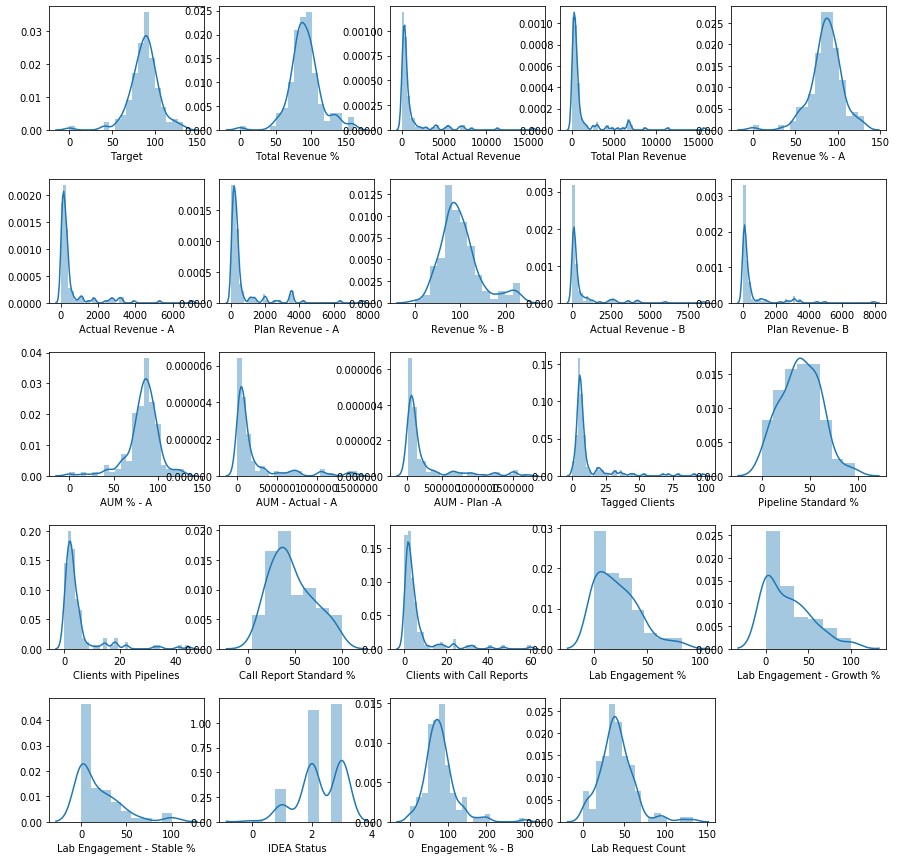

In [12]:
# plotHistograms(df)
plotDist(df)
# plotBoxPlots(df)

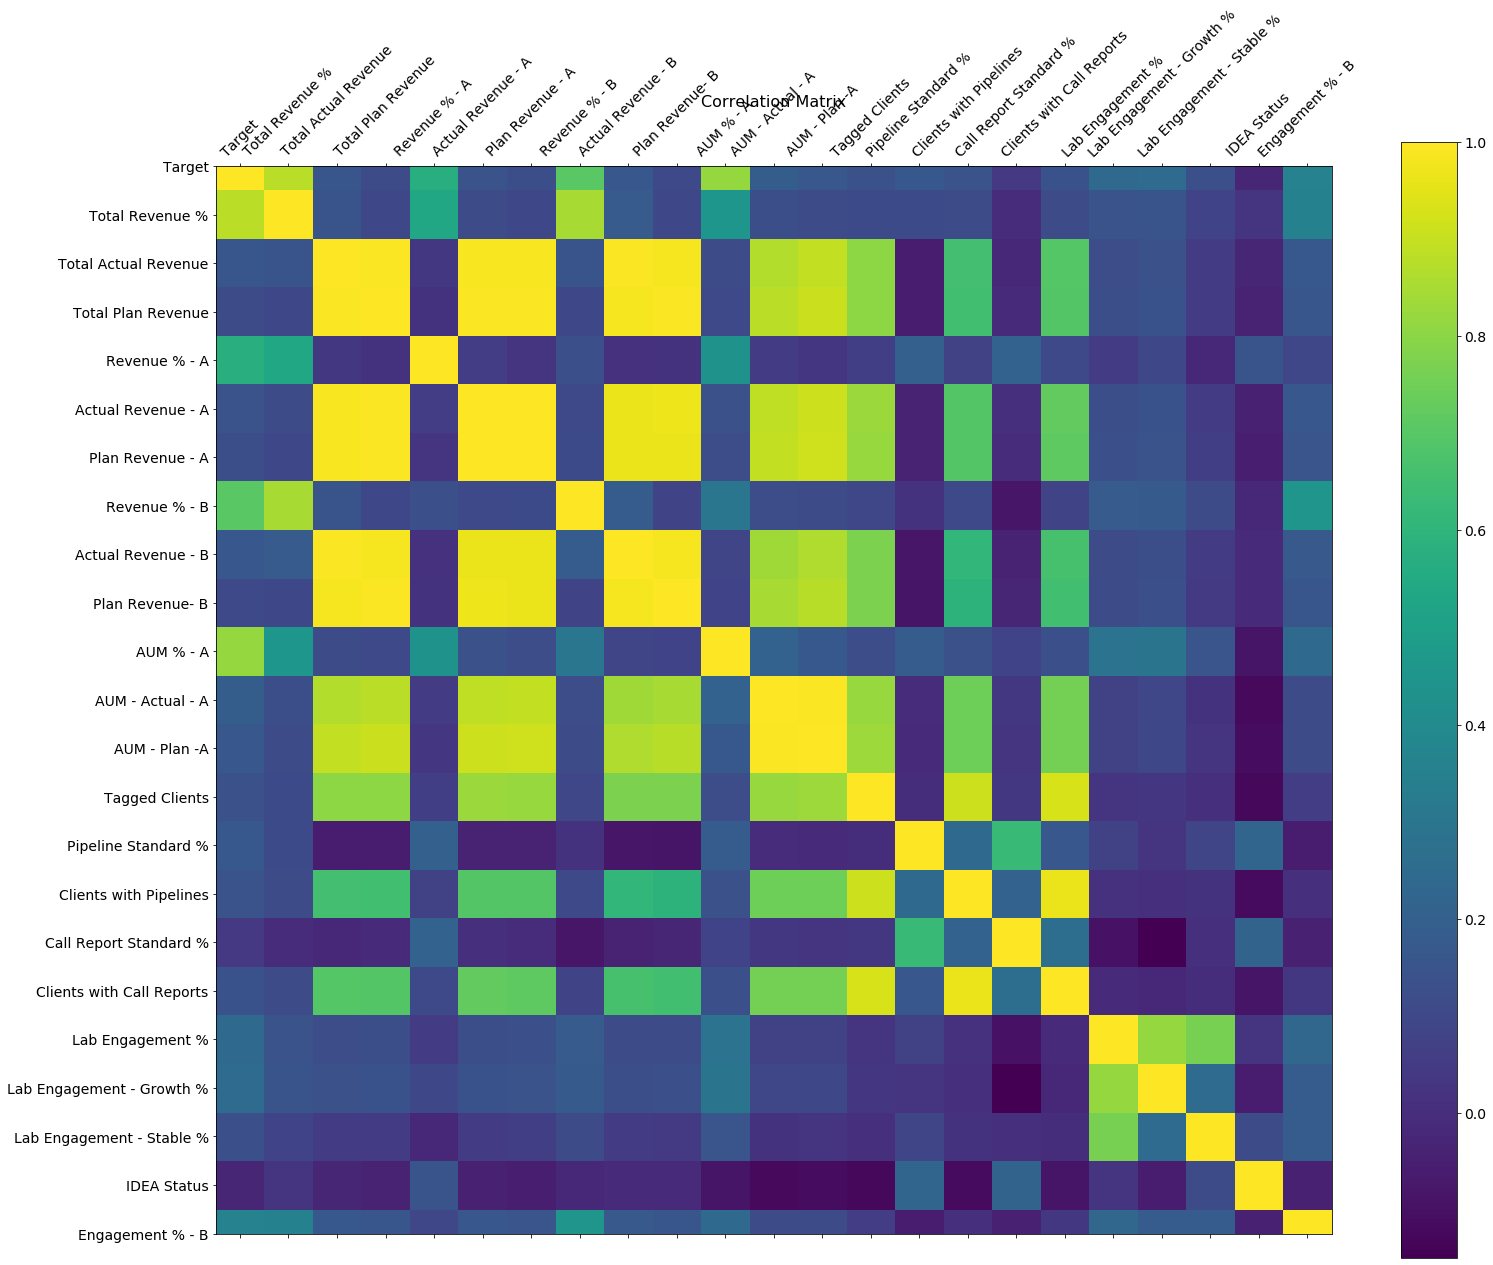

In [13]:
# Correlation Matrix show that no non financial matrix is strongly correlated with the Target
plotCorrMatrix(df.loc[:,'Target':'Engagement % - B'])

In [14]:
# Preprocessing pt2

# Min Bin Right tailed data for data smoothing, outlier effect reduction
colsToBinMin = [#'Target',
            #'Total Revenue %',
            'Total Actual Revenue',
            'Total Plan Revenue',
            #'Revenue % - A',
            'Actual Revenue - A',
            'Plan Revenue - A',
            #'Revenue % - B',
            'Actual Revenue - B',
            'Plan Revenue- B',
            #'AUM % - A',
            'AUM - Actual - A',
            'AUM - Plan -A',
            'Tagged Clients',
            #'Pipeline Standard %',
            'Clients with Pipelines',
            #'Call Report Standard %',
            #'Clients with Call Reports',
            #'Lab Engagement %',
            #'Lab Engagement - Growth %',
            #'Lab Engagement - Stable %',
            #'IDEA Status',
            'Engagement % - B'
            #'Lab Request Count'
            ]


# Mean bin data for data smoothing
df_bin = featureBinning(df, colsToBinMin, method='min', binsize=5)

colsToBinMean = []

# bin data for data smoothing
# df_bin = featureBinning(df, colsToBinMean, method='mean', binsize=4)

# df_bin.head()
# df_bin.describe()

In [15]:
# data visualization - histograms: post binning        
# plotHistograms(df_bin)
# plotDist(df_bin)

### Dimensionality Reduction (PCA/SVD) - Part 1
##### Separating out 'Team Leads' with PCA with SVD and dbscan clustering

In [16]:
#df0 = df     # if no prepocessing steps are done
df0 = df_bin.to_numpy()

In [17]:
# Preprocess Data for Dimensionality Reduction

x = StandardScaler().fit_transform(df0)
x1 = Normalizer().fit_transform(x)

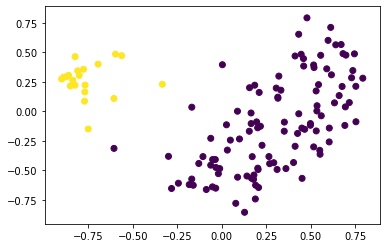

In [18]:
# Dimensionality Reduction Using SVD
u, s, vh = np.linalg.svd(x1)
sigma = np.diag(s)

# IC's to concept space
svd_reduced = np.dot(u[:,0:2], sigma[0:2,:])

# DBSCAN - Used to separate out 'Team Leads'. Kmeans did not converge 'correctly'.

from sklearn.cluster import DBSCAN
X = StandardScaler().fit_transform(svd_reduced[:,0:2])
dbscan = DBSCAN(eps=0.75, min_samples=7).fit_predict(X)
plt.scatter(x=svd_reduced[:,0], y=svd_reduced[:,1], c=dbscan)
plt.show()

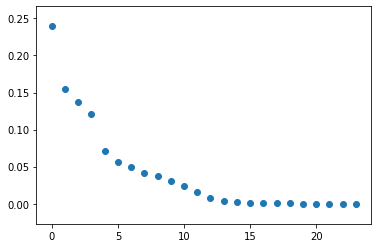

eigenval 1: 0.23913305828405054
eigenval 2: 0.15530174974254415
total:      0.3944348080265947


In [19]:
# plotting explained variation
s2 = [math.pow(i,2) for i in s]
totvar = sum(s2)
variance = np.array(s2)/totvar

plt.scatter(x=[i for i in range(len(s))], y=variance)
plt.show()

v1 = variance[0]
v2 = variance[1]
v3 = variance[2]
print('eigenval 1: ' + str(v1))
print('eigenval 2: ' + str(v2))
print('total:      ' + str(v1 + v2))

In [20]:
def reindexGroupByAvgTarget(df, target='Target', group='KMeans', incr=0):
    """
    Reindexes KMeans numerical catagory based on target means
    
    parameters
    ----------
    inc = increments group value 
    """
    
    groups = pd.Series(df[group]).unique()
    means = []
    for g in groups:
        means.append((g, df.loc[df[group] == g][target].mean()))
    means = sorted(means, key=lambda x: x[1], reverse=True) # rev = True = descending order    
    newvals = {}
    for i in range(len(means)):
        newvals[means[i][0]] = i + incr
    res = df[group].replace(newvals)
    return res 
    
def plotkde(df, by='', num_cols=5):
    titles = list(df)
    num_features = df.shape[1]
    num_rows= 1 + num_features // num_cols
    size = 3
    fig = plt.figure(figsize=(num_cols * size,num_rows * size))

    if by:
        # separate distribution by 'by' column
        groups = np.sort(pd.Series(df[by]).unique())

        for i in range(df.shape[1] - 1):
            ax = fig.add_subplot(num_rows,num_cols,i+1)
            ax.set_title(titles[i])
            for g in groups:
                sns.kdeplot(df.loc[df[by] == g].iloc[:,i], ax=ax, legend=False)
    else:
        # single estimated dist for all data
        for i in range(df.shape[1]):
            ax = fig.add_subplot(num_rows,num_cols,i+1)
            ax.set_title(titles[i])
            sns.kdeplot(df.iloc[:,i], ax=ax, legend=False)        
    
    
    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    plt.show()
    
def plotBox(df, by='', num_cols=5, swarm=False):
    titles = list(df)
    num_features =df.shape[1]
    num_rows= 1 + num_features // num_cols
    size = 3
    fig = plt.figure(figsize=(num_cols * size,num_rows * size))
    
    for i in range(df.shape[1] - 1):
        ax = fig.add_subplot(num_rows,num_cols,i+1)
        ax.set_title(titles[i])

        sns.boxplot(x=by, y=df.iloc[:,i], data=df, ax=ax, dodge=True, whis=np.inf)

        if swarm:
            sns.swarmplot(x=by, y=df.iloc[:,i], data=df, ax=ax, color=".25")
            
    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    plt.show()    

In [21]:
df['group'] = dbscan
df['group'] = reindexGroupByAvgTarget(df, target='AUM - Plan -A', group='group')

In [22]:
grpA = df.loc[df['group'] == 0]
grpB = df.loc[df['group'] == 1]

meanA = grpA.loc[:,'Target':'Engagement % - B'].mean(axis=0, skipna=True)
meanB = grpB.loc[:,'Target':'Engagement % - B'].mean(axis=0, skipna=True)

stdA = grpA.loc[:,'Target':'Engagement % - B'].std(axis=0, skipna=True)
stdB = grpB.loc[:,'Target':'Engagement % - B'].std(axis=0, skipna=True)

def plotBarChart(data_mean, data_std, titles, num_cols=5):
    num_features = len(titles)
    num_rows= 1 + num_features // num_cols
    size = 3
    fig = plt.figure(figsize=(num_cols * size,num_rows * size))
    width = 0.4 
    
    for i in range(num_features):
        
        ax = fig.add_subplot(num_rows,num_cols,i+1)
        
        rects1 = ax.bar(0, data_mean[0][i], width, yerr=data_std[0][i], label='A')
        rects2 = ax.bar(1, data_mean[1][i], width, yerr=data_std[1][i], label='B')
        
        ax.set_title(titles[i])
        ax.set_xticks([0, 1])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    plt.show()

grpA size: 20
grpB size: 110


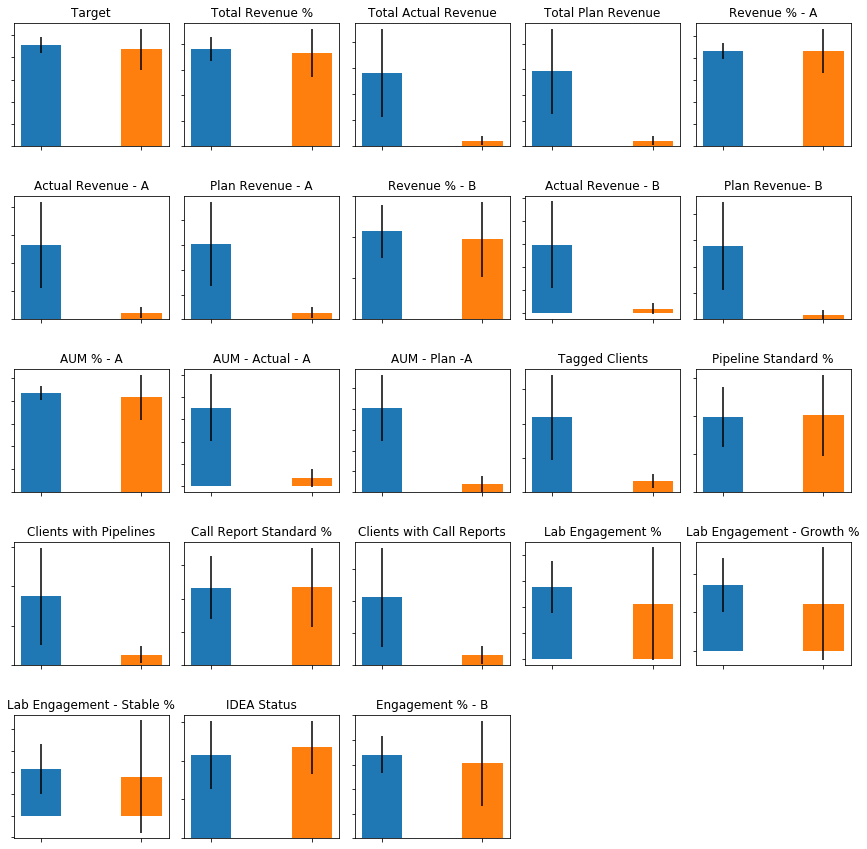

In [23]:
print('grpA size: ' + str(grpA.shape[0]))
print('grpB size: ' + str(grpB.shape[0]))
plotBarChart([meanA, meanB], [stdA, stdB], df.loc[:,'Target':'Engagement % - B'].columns.values)

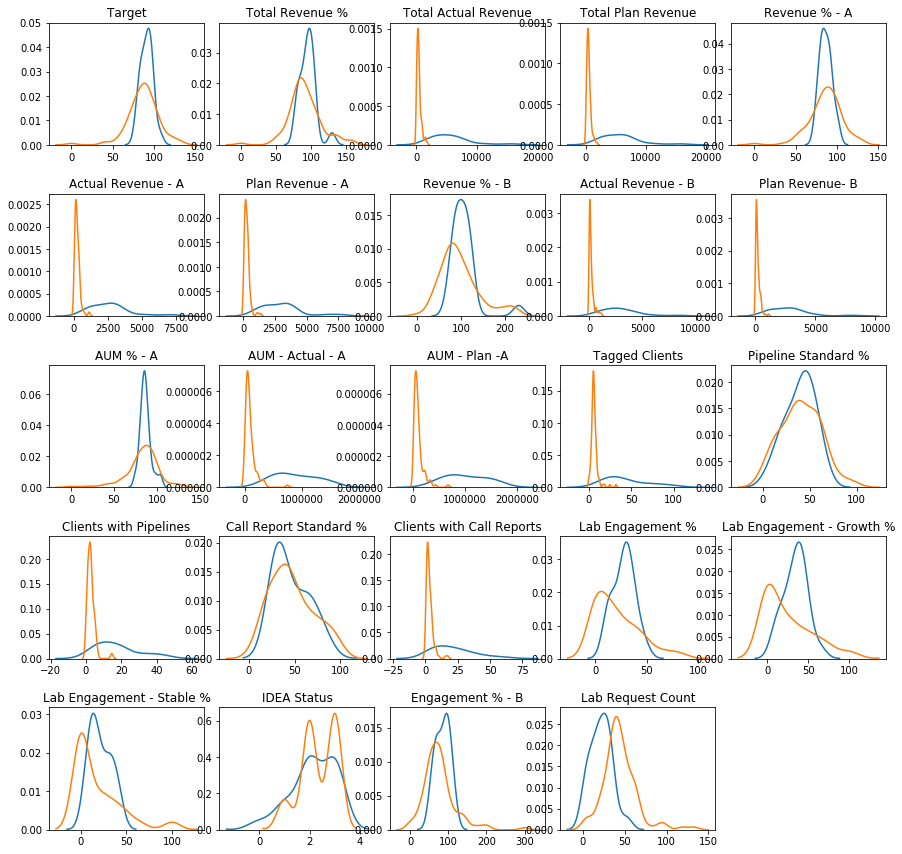

In [24]:
plotkde(df.loc[:,'Target':'group'], by='group')

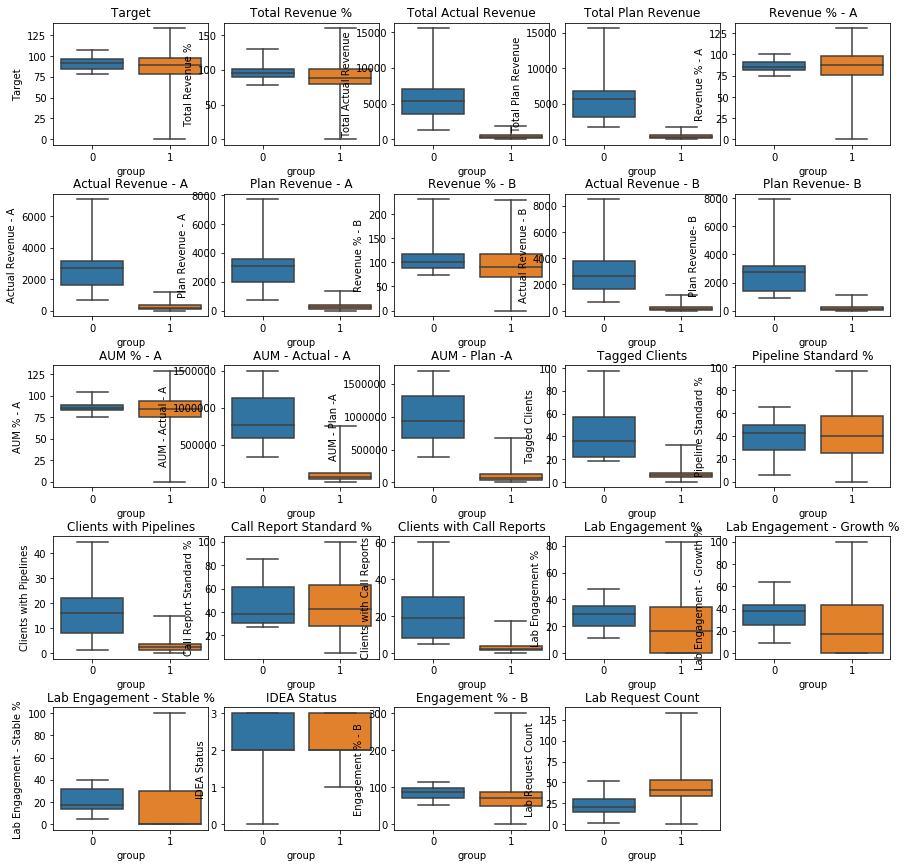

In [25]:
plotBox(df.loc[:,'Target':'group'], by='group')

### Dimensionality Reduction (PCA/SVD) - Part 2

#### Clustering on non 'Team Leads'

In [26]:
# Remove 'Team Leads'
df1 = df.loc[df['group'] == 1].copy()

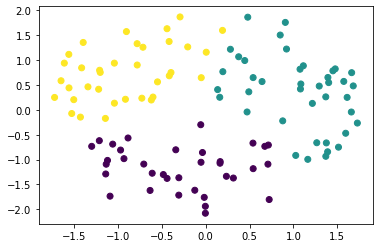

In [27]:
# PCA on reduced data set
x0 = df1.loc[:,'Target':'Lab Request Count'].to_numpy()
x0 = StandardScaler().fit_transform(x0) 
x0 = Normalizer().fit_transform(x0)

u, s, vh = np.linalg.svd(x0)
sigma = np.diag(s)

# IC's to concept space
svd_reduced = np.dot(u[:,0:2], sigma[0:2,:])

X = StandardScaler().fit_transform(svd_reduced[:,0:2])

kmeans = KMeans(n_clusters=3, random_state=77, max_iter=600).fit_predict(X)
plt.scatter(x=X[:,0], y=X[:,1], c=kmeans)

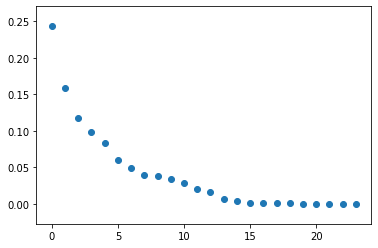

eigenval 1: 0.24303456521671152
eigenval 2: 0.15828084579825177
total:      0.40131541101496326


In [28]:
# plotting explained variation from singular values
s2 = [math.pow(i,2) for i in s]
totvar = sum(s2)
variance = np.array(s2)/totvar

plt.scatter(x=[i for i in range(len(s))], y=variance)
plt.show()

v1 = variance[0]
v2 = variance[1]
v3 = variance[2]
print('eigenval 1: ' + str(v1))
print('eigenval 2: ' + str(v2))
print('total:      ' + str(v1 + v2))

# print(sum(variance[0:10]))

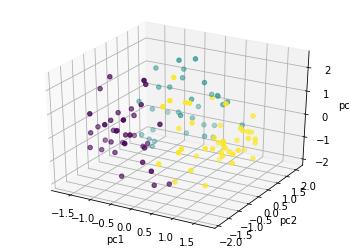

In [29]:
pca = PCA(n_components=3)
pca_matrix0 = pca.fit_transform(x0)

X = StandardScaler().fit_transform(pca_matrix0)

# Kmeans of dim reduced matrix
kmeans = KMeans(n_clusters=3, random_state=7, max_iter=600).fit_predict(pca_matrix0)

fig = plt.figure(figsize=(6,20))
ax0 = fig.add_subplot(411, projection='3d', xlabel='pc1', ylabel='pc2', zlabel='pc3')

ax0.scatter(xs=X[:,0], ys=X[:,1], zs=X[:,2], c=kmeans)

plt.show()

In [30]:
df1.drop(labels=['group'], axis=1)
df1['group'] = kmeans
df1['group'] = reindexGroupByAvgTarget(df1, group='group', incr=1)

group1:36
group2:32
group3:42


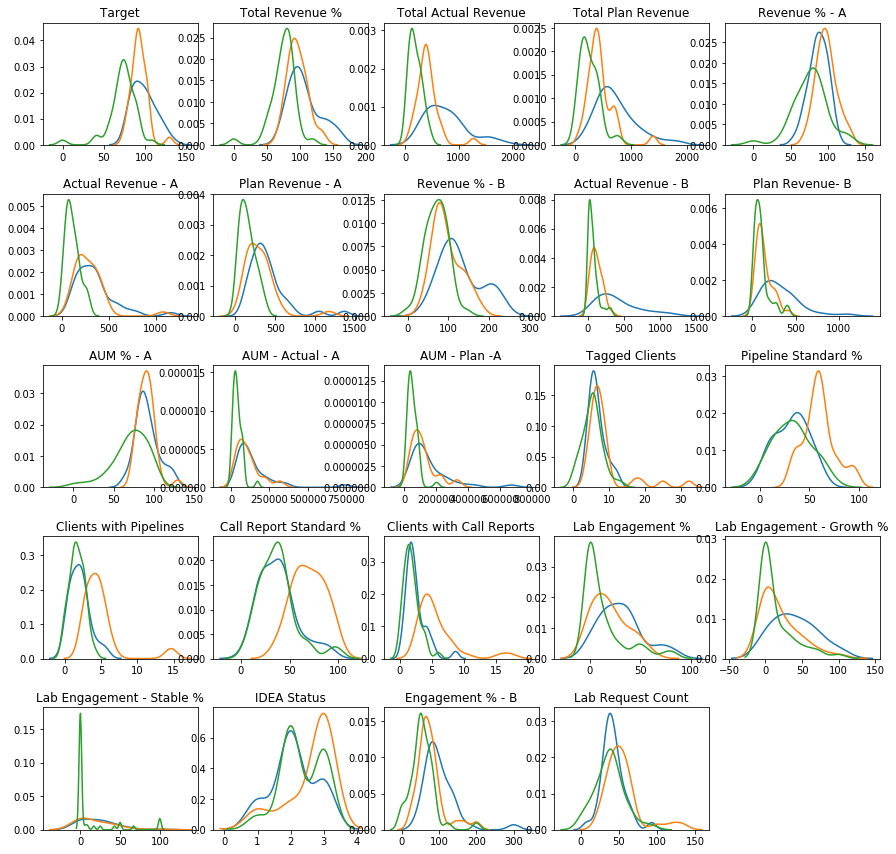

In [31]:
groupNum = pd.Series(df1['group']).unique()

for i in range(len(groupNum)):
    print("group" + chr(ord('1')+i) + ':' + str(df1.loc[df1['group'] == groupNum[i]].shape[0]))

plotkde(df1.loc[:,'Target':'group'], by='group') 

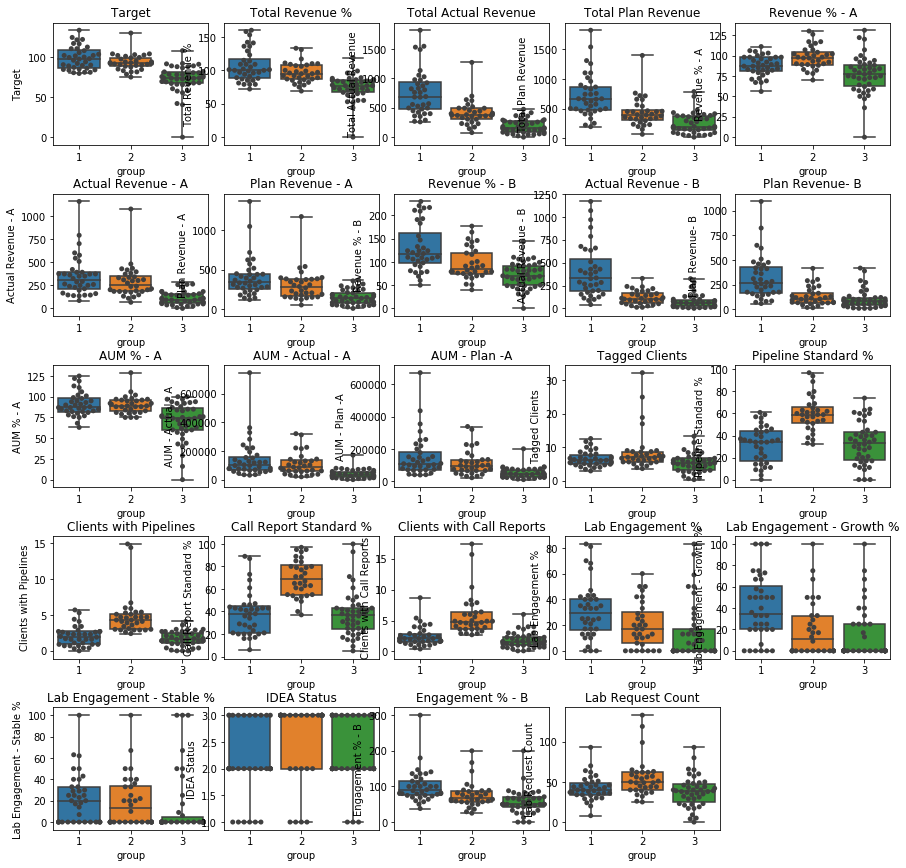

In [32]:
plotBox(df1.loc[:,'Target':'group'], by='group', swarm=True)

#### Observations

###### Group Blue

    - Financials: 
        - Highest Total, A, and B plan
        - Highest AUM mean
    - Non-Financials:
        - Highest Lab Engagement
    - Summary: Likely more senior IC's

###### Group Orange

    - Financials: 
    - Non-Financials:
        - Most Clients withs Pipelines
        - Most Call Report Standard %
        - Most Clients with Call Reports
    - Summary: Possibly Higher Performing Junior IC's

###### Group Green

    - Financials: 
    - Non-Financials:
        - lowest Lab Engagment %
    - Summary: Possibly Lower Performing Junior IC's
    
Orange and Green are more similar when looking at financial metrics. If they're are no institution level differences between these two groups, we could create a linear regression model that could suggest work flow improvements reflected in the non-financial metrics.

Next Steps:

- Test Linear Regression Model for Orange, Green, and Orange+Green pooled.

- Repeat by dividing Cohort of IC's not by kmeans, but by an interpretable threshold, likely (Total Plan Revenue). This could translate into models for "IC's with low B Plan"

- Analyze Blue (group 1) and TL (group 0) IC's individually.

- We could create a new 'Target' value that is relative to region performance.

#### Linear Regression 

#### Linear regression model to predict target of group 0 (blue) using non financial metrics

In [33]:
df_grp = df1.loc[df1['group'] == 2].loc[:,'Target':'Lab Request Count'].copy()

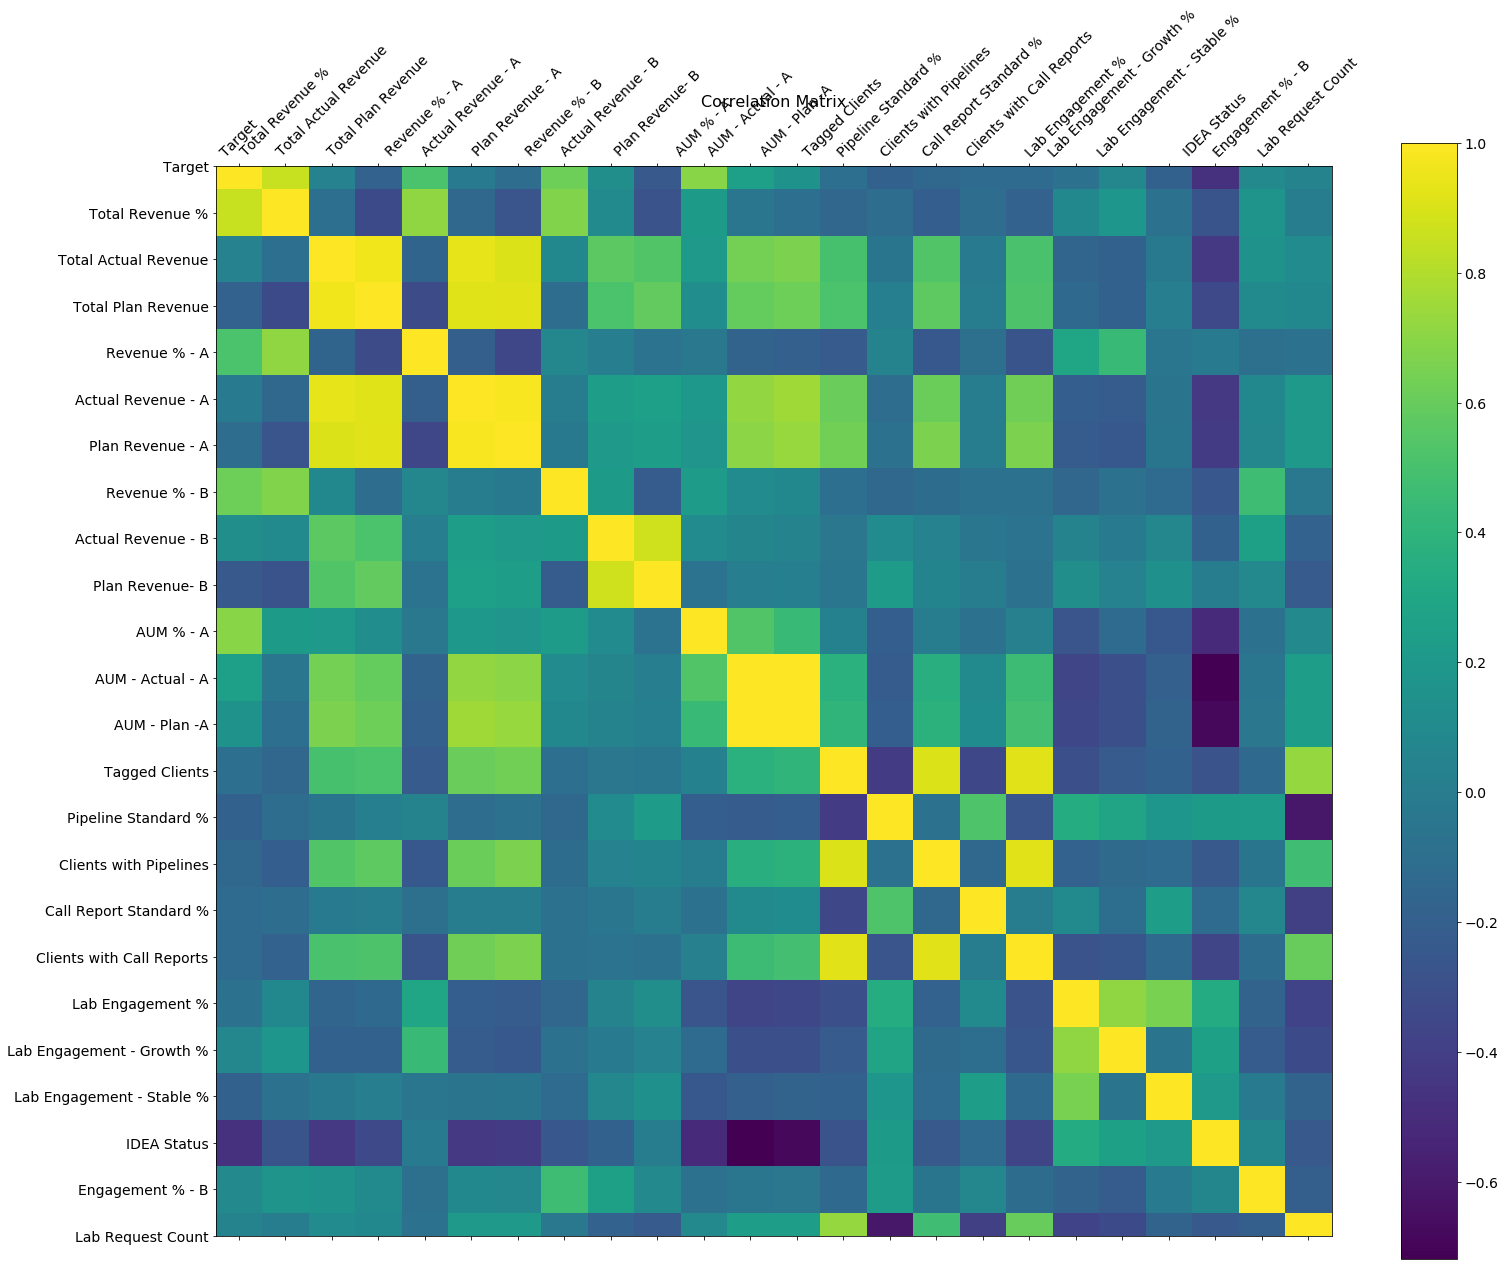

In [34]:
# Correlation Matrix 
plotCorrMatrix(df_grp)

In [35]:
colsToDrop = [#'Target',
            'Total Revenue %',
            'Total Actual Revenue',
            'Total Plan Revenue',
            'Revenue % - A',
            'Actual Revenue - A',
            'Plan Revenue - A',
            'Revenue % - B',
            'Actual Revenue - B',
            'Plan Revenue- B',
            'AUM % - A',
            'AUM - Actual - A',
            'AUM - Plan -A',
            #'Tagged Clients',
            #'Pipeline Standard %',
            #'Clients with Pipelines',
            #'Call Report Standard %',
            #'Clients with Call Reports',
            #'Lab Engagement %',
            #'Lab Engagement - Growth %',
            #'Lab Engagement - Stable %',
            #'IDEA Status',
            #'Engagement % - B'
            #'Lab Request Count'
            ]

df_grp = df_grp.drop(labels=colsToDrop, axis=1)
df_grp.head()

Target  Tagged Clients  Pipeline Standard %  Clients with Pipelines  \
1     95.0             4.9                 97.0                     4.7   
5    101.0             9.9                 61.0                     6.0   
6    130.0             8.6                 53.0                     4.6   
7    104.0             7.6                 68.0                     5.1   
11    99.5             4.4                 94.0                     4.1   

    Call Report Standard %  Clients with Call Reports  Lab Engagement %  \
1                     97.0                        4.7               0.0   
5                     80.0                        7.9              13.0   
6                     53.0                        4.6               6.0   
7                     85.0                        6.4              60.0   
11                    61.0                        2.7              50.0   

    Lab Engagement - Growth %  Lab Engagement - Stable %  IDEA Status  \
1                         0.0                        0.0          3.0   
5                        17.0                       10.0          3.0   
6                        13.0                        0.0          1.0   
7                        20.0                      100.0          2.0   
11                      100.0                        0.0          3.0   

    Engagement % - B  Lab Request Count  
1              167.0               34.0  
5              143.0               69.0  
6               77.0               62.0  
7               82.0               59.0  
11              50.0               32.0

In [36]:
# Preprocessing

# Split Target and Features

y = df_grp.pop('Target')

x = df_grp

# Preprocesing Features
colsToBinMin = [
            'Tagged Clients',
            #'Pipeline Standard %',
            'Clients with Pipelines',
            #'Call Report Standard %',
            'Clients with Call Reports',
            #'Lab Engagement %',
#             'Lab Engagement - Growth %',
#             'Lab Engagement - Stable %',
#             'IDEA Status',
            'Engagement % - B',
            'Lab Request Count'
            ]

x = featureBinning(x, colsToBinMin, method='min', binsize=6)

x = StandardScaler().fit_transform(x)

x = MinMaxScaler().fit_transform(x)

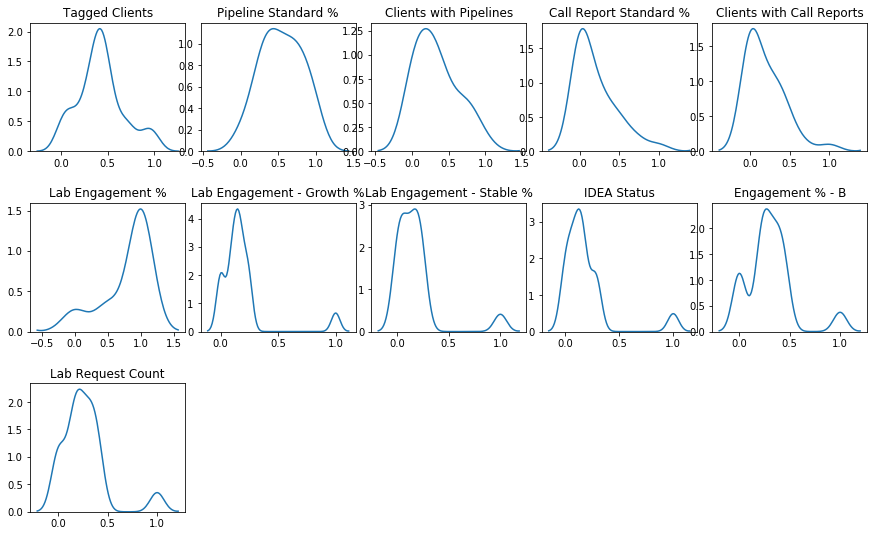

In [37]:
# Visualized Preprocessed Data
# NEED TO CLIP VALUES FOR LAB ENGAGEMENT GROWTH, ENGAGEMENT B, etc

processed_x = pd.DataFrame(data=x, columns=df_grp.columns.values)
plotkde(processed_x) 

<function matplotlib.pyplot.show(*args, **kw)>

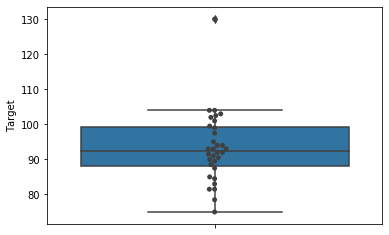

In [38]:
sns.boxplot(y=y, data=df)
sns.swarmplot(y=y, data=df, color=".25")
plt.show

In [39]:
# Model (Deep)

# , kernel_regularizer=keras.regularizers.l2(.1)

def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[x.shape[1]]),
        keras.layers.Dense(64, activation=tf.nn.relu),
        #keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [40]:
model = build_model()

In [41]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

history = model.fit(
  x, y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, shuffle=True,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [42]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

val_loss  val_mean_absolute_error  val_mean_squared_error       loss  \
495  664.826172                18.635157              664.826172  51.416256   
496  714.002075                19.594744              714.002075  51.230015   
497  664.510193                18.653879              664.510193  50.990406   
498  712.529724                19.590105              712.529724  50.783890   
499  663.137390                18.648968              663.137390  50.579735   

     mean_absolute_error  mean_squared_error  epoch  
495             5.530895           51.416256    495  
496             5.419695           51.230015    496  
497             5.498543           50.990406    497  
498             5.391632           50.783890    498  
499             5.465556           50.579735    499

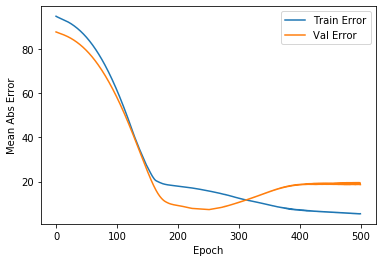

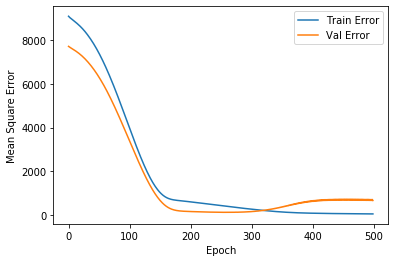

In [43]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

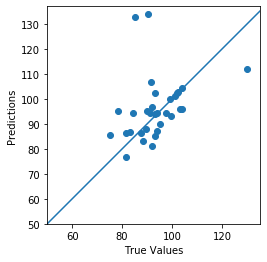

In [44]:
test_predictions = model.predict(x).flatten()

plt.scatter(y, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([50,plt.xlim()[1]])
plt.ylim([50,plt.ylim()[1]])
_ = plt.plot([-200, 200], [-200, 200])

In [45]:
# OLS model

def build_model():
    model = keras.Sequential([
    keras.layers.Dense(1, 
                       activation="linear", 
                       input_shape=[x.shape[1]], 
                       kernel_regularizer=keras.regularizers.l2(0.01)
                      )
    ])

    optimizer = keras.optimizers.SGD(lr=0.01)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [46]:
model = build_model()

In [47]:
# Display training progress by printing a single dot for each completed epoch
EPOCHS = 1000

history = model.fit(
  x, y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, shuffle=True,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [48]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

val_loss  val_mean_absolute_error  val_mean_squared_error        loss  \
995  121.726021                 8.966757              109.660416  114.635284   
996  121.817070                 8.968205              109.750504  114.540909   
997  121.908081                 8.969651              109.840561  114.446762   
998  121.999023                 8.971093              109.930542  114.352791   
999  122.090050                 8.972537              110.020615  114.259048   

     mean_absolute_error  mean_squared_error  epoch  
995             7.381239          102.570633    995  
996             7.377473          102.475304    996  
997             7.373712          102.380196    997  
998             7.369955          102.285271    998  
999             7.366201          102.190567    999

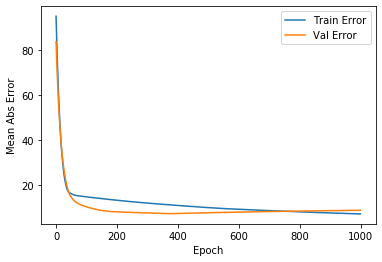

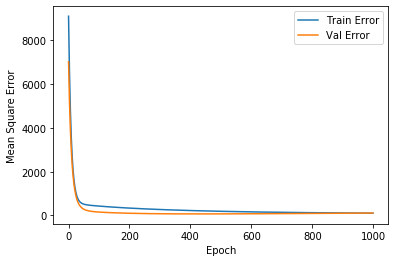

In [49]:
plot_history(history)

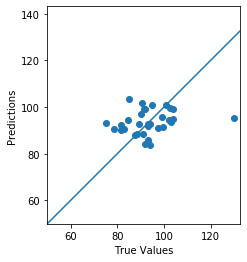

In [50]:
test_predictions = model.predict(x).flatten()

plt.scatter(y, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([50,plt.xlim()[1]])
plt.ylim([50,plt.ylim()[1]])
_ = plt.plot([-200, 200], [-200, 200])

In [51]:
weights = pd.DataFrame(data=model.get_weights()[0], columns=['weight'], index=df_grp.columns.values)
weights

weight
Tagged Clients              1.968385
Pipeline Standard %        11.032489
Clients with Pipelines      1.970262
Call Report Standard %      9.762039
Clients with Call Reports  -6.670736
Lab Engagement %           -0.500717
Lab Engagement - Growth %   3.427161
Lab Engagement - Stable %  -6.533317
IDEA Status                 0.959762
Engagement % - B           14.599468
Lab Request Count          25.863661

In [52]:
df_grp['Lab Request Count']

1      34.0
5      69.0
6      62.0
7      59.0
11     32.0
13     37.0
15     56.0
19     40.0
20     39.0
21     45.0
22     25.0
24     40.0
25     62.0
28     62.0
29     54.0
31     50.0
34     49.0
37     63.0
39     36.0
42     26.0
47     44.0
54     44.0
55     43.0
63     56.0
65     65.0
69     51.0
74     49.0
75     57.0
80     99.0
82    119.0
84     49.0
90    133.0
Name: Lab Request Count, dtype: float64

### Notes from Meeting (7/24/2019)
- Linear regression


### Notes from Meeting (7/17/2019)
- find best performing IC per cohort
- 'how to be a better ic -  what tools, what partners, behaviors / activities'
- 'prediction 1/0 head or behind'
- 'avg sales? '

### Column Names

"""
'Name',
'Region',
'Sub-Region',
'Total Revenue %',
'Total Actual Revenue',
'Total Plan Revenue',
'A Revenue %',
'A Actual Revenue',
'A Plan Revenue',
'B Revenue %',
'B Actual Revenue',
'B Plan Revenue',
'A AUM %',
'A AUM - Actual',
'A AUM - Plan',
'Tagged Clients',
'Pipeline Standard %',
'Clients with Pipelines',
'Call Report Standard %',
'Clients with Call Reports',
'Lab Engagement %',
'Lab Engagement - Growth %',
'Lab Engagement - Stable %',
'IDEA Status',
'B Engagement %'

"""

In [171]:
df.columns

Index(['Unnamed: 0', 'Name', 'Region', 'Sub-Region', 'Target',
       'Total Revenue %', 'Total Actual Revenue', 'Total Plan Revenue',
       'Revenue % - A', 'Actual Revenue - A', 'Plan Revenue - A',
       'Revenue % - B', 'Actual Revenue - B', 'Plan Revenue- B', 'AUM % - A',
       'AUM - Actual - A', 'AUM - Plan -A', 'Tagged Clients',
       'Pipeline Standard %', 'Clients with Pipelines',
       'Call Report Standard %', 'Clients with Call Reports',
       'Lab Engagement %', 'Lab Engagement - Growth %',
       'Lab Engagement - Stable %', 'IDEA Status', 'Engagement % - B',
       'Lab Request Count', 'group', 'Target_meet'],
      dtype='object')

In [172]:
df['Target_meet'] = np.where(df['Total Revenue %']>=90,1,0)

In [173]:
df

Unnamed: 0     Name Region Sub-Region  Target  Total Revenue %  \
0            10   Name12      A          H   107.0            130.0   
1            99  Name110      C          J    85.0             90.0   
2            93  Name104      B          Q    83.5             86.0   
3            87   Name96      B          F    88.0             90.0   
4            85   Name94      D          C    83.5             78.0   
5            76   Name84      B          P    93.5             98.0   
6            73   Name81      B          N    82.5             82.0   
7            72   Name80      B          N    82.5             82.0   
8            64   Name71      A          D    89.5             95.0   
9            57   Name63      C          M    96.5             95.0   
10           94  Name105      B          O    78.0             81.0   
11           49   Name54      A          D    96.0            105.0   
12           48   Name53      D          L    97.5            103.0   
13           46   Name51      A          D    96.0            105.0   
14           40   Name43      A          H    90.0            100.0   
15           36   Name39      D          R    98.5             93.0   
16           35   Name38      D          E    92.5             98.0   
17           30   Name33      D          L    97.5            103.0   
18           23   Name25      A          H    90.5             95.0   
19           51   Name56      A          D    92.5            100.0   
20           27   Name30      C          M   110.5            153.0   
21           71   Name78      C          M   108.0             94.0   
22           70   Name77      A          D    92.0             97.0   
23           32   Name35      A          H    85.0             85.0   
24           33   Name36      A          D   112.5            123.0   
25           67   Name74      D          L    90.5            100.0   
26           66   Name73      B          Q    94.0             87.0   
27           45   Name50      C          A    90.0             89.0   
28           62   Name68      A          H    83.5             85.0   
29           43   Name47      B          O   110.5            136.0   
..          ...      ...    ...        ...     ...              ...   
100         123  Name136      A          D    67.0             67.0   
101         124  Name137      C          A    57.5             72.0   
102         125  Name138      C          J    66.0             70.0   
103         126  Name139      B          P    66.0             75.0   
104         127  Name140      C          J    68.0             71.0   
105         128  Name141      C          M    55.5             95.0   
106         119  Name131      B          N    65.5             55.0   
107         109  Name120      B          P    81.5             66.0   
108         105  Name116      A          D    72.5             86.0   
109         107  Name118      C          A    74.0             74.0   
110          78   Name86      D          G    88.0             84.0   
111          79   Name87      C          J    80.5             77.0   
112          68   Name75      B          Q    89.0             84.0   
113          81   Name89      B          Q    92.0             99.0   
114          83   Name91      B          N    73.5             73.0   
115          88   Name97      D          C    80.5             86.0   
116          41   Name45      B          F   108.0            119.0   
117          91  Name101      C          J    91.5             83.0   
118         108  Name119      B          P    73.5             55.0   
119          92  Name102      C          J    88.0             89.0   
120          44   Name49      B          P    89.0             78.0   
121         129  Name142      C          A    40.5             52.0   
122         100  Name111      D          B    78.5             82.0   
123         101  Name112      D          E    67.5             86.0   
124         102  Name113     

In [174]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
%matplotlib inline
from sklearn.model_selection import train_test_split

In [175]:
features = ['AUM % - A', 'AUM - Actual - A', 'AUM - Plan -A',
       'Tagged Clients', 'Pipeline Standard %', 'Clients with Pipelines',
       'Call Report Standard %', 'Clients with Call Reports',
       'Lab Engagement %', 'Lab Engagement - Growth %',
       'Lab Engagement - Stable %', 'IDEA Status', 'Engagement % - B',
       'Lab Request Count']

X = df[features].values

In [176]:
y = df[['Target_meet']]

In [177]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X, y)
m.score(X,y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.8344615384615385

In [199]:
type(Target_meet)

NameError: name 'Target_meet' is not defined

In [178]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

In [179]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

n_valid = 100 
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(X, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((30, 14), (30, 1), (100, 14))

In [180]:
#define a function to check rmse value
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

In [181]:
def print_score(m):
    res = [rmse(m.predict(X_train), y_train),
           rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [193]:
m = RandomForestRegressor(n_estimators=20, max_depth=4, min_samples_leaf=2, max_features=0.5, bootstrap=True, oob_score=True, n_jobs=-1)
%time m.fit(X_train, y_train)
m.score(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


Wall time: 126 ms


0.7310443121693121

In [197]:
type(features)

list

In [203]:
from sklearn.tree import export_graphviz
estimator = m.estimators_[5]
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features,
                class_names = y_train,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')

In [204]:
os.system('dot -Tpng tree.dot -o tree.png')

1

In [185]:
n_estimatorsList=[1,10,50,100];
max_depthList=[1,2,3];
min_samples_leafList=[1,2,3];
max_featuresList=[0.2,0.3,0.5];
for n_est in n_estimatorsList :
        for max_depth in max_depthList :
            for min_s_leaf in min_samples_leafList:
                for max_feature in max_featuresList:
                    m = RandomForestRegressor(n_estimators=n_est, max_depth=max_depth, min_samples_leaf=min_s_leaf, max_features=max_feature, bootstrap=True, oob_score=True, n_jobs=-1)
                    m.fit(X_train, y_train.values.ravel())
                    m.score(X_train, y_train.values.ravel())
#the min_sample_leaf as 3. This means that the minimum number of samples in the node should be 3 for each split.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OO

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [186]:
def draw_tree(t, df, size=40, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file="tree1.png", 
                                     max_depth=2, feature_names=130, filled=True, special_characters=True, 
                                     proportion=False, rotate=True, rounded=False, 
                                     precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree:{', f'Tree {{ size={size}; ratio={ratio}',s)))

In [188]:
draw_tree(m.estimators_[0], X_train, precision=3)

TypeError: object of type 'int' has no len()

In [170]:
import matplotlib.pyplot as plt
import scipy
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train.columns,
    orientation='left', leaf_font_size=16)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

<Figure size 1152x720 with 0 Axes>

In [ ]:
df

In [165]:
import matplotlib.pyplot as plt
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols': df.columns,'imp' :
    m.feature_importances_}).sort_values('imp',ascending = False)
#fi = rf_feat_importance(m,df)

fi = rf_feat_importance(m, X); fi[:10]

#def plot_fi(fi):
 #     return fi.plot('cols', 'imp', 
  #    'barh' figsize=(20,12), legend=False)
#plot_fi(fi[:50])

Exception: Data must be 1-dimensional

In [89]:
#np.stack will be used to concatenate the predictions one over the other
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

In [90]:
#The dimensions of the predictions is (1, 100) . This means we have 1 prediction for each row in the validation set.
preds.shape 

(1, 100)

In [70]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ValueError: Unable to coerce to Series, length must be 1: given 30

In [41]:
Targetmeet = DecisionTreeClassifier(criterion="entropy", splitter = 'best', max_depth = 4)
Targetmeet 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
Targetmeet.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [31]:
predTree = Targetmeet.predict(X_testset)

In [32]:
print (predTree [0:5])
print (y_testset [0:5])

[1 0 0 1 1]
     Target_meet
42             1
82             1
112            0
108            0
15             1


In [35]:
Targetmeet.fit(X_trainset,y_trainset)
#Prediction
predTree=Targetmeet.predict(X_testset)
#importing the metrics module
from sklearn import metrics
#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(predTree,y_testset))
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",metrics.confusion_matrix(predTree,y_testset))

Accuracy: 0.6666666666666666
Confusion Metrix:
 [[15  9]
 [ 4 11]]


In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
#making the instance
Targetmeet= DecisionTreeClassifier(random_state=1234)
#Hyper Parameters Set
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10], 
          'min_samples_leaf':[1,2,3,4,5],
          'random_state':[123]}
#Making models with hyper parameters sets
model1 = GridSearchCV(Targetmeet, param_grid=params, n_jobs=-1)
#Learning
model1.fit(X_trainset,y_trainset)
#The best hyper parameters set
print("Best Hyper Parameters:",model1.best_params_)
#Prediction
prediction=model1.predict(X_testset)
#importing the metrics module
from sklearn import metrics
#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(predTree,y_testset))
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",metrics.confusion_matrix(predTree,y_testset))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Hyper Parameters: {'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 123}
Accuracy: 0.6666666666666666
Confusion Metrix:
 [[15  9]
 [ 4 11]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [48]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.6666666666666666


In [50]:
featureNames = df.columns[0:24]
featureNames

Index(['Unnamed: 0', 'Name', 'Region', 'Sub-Region', 'Target',
       'Total Revenue %', 'Total Actual Revenue', 'Total Plan Revenue',
       'Revenue % - A', 'Actual Revenue - A', 'Plan Revenue - A',
       'Revenue % - B', 'Actual Revenue - B', 'Plan Revenue- B', 'AUM % - A',
       'AUM - Actual - A', 'AUM - Plan -A', 'Tagged Clients',
       'Pipeline Standard %', 'Clients with Pipelines',
       'Call Report Standard %', 'Clients with Call Reports',
       'Lab Engagement %', 'Lab Engagement - Growth %'],
      dtype='object')